In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import Model
import unicodedata
import time

In [2]:
n_mels = 80
fs = 22050
frame_length_ms=50
frame_shift_ms=12.5
nsc = int(22050 * frame_length_ms / 1000)
nov = nsc - int(22050 * frame_shift_ms / 1000)
nhop = int(22050 * frame_shift_ms / 1000)
eps = 1e-10
db_ref = 100

chars = ''' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!\'\"(),-.:;?'''

num_tokens = len(chars)

embed_size = 256

K = 16

num_conv1d_filters = 128

prenet_size = [256, 128]

num_enc_proj_filters = [128, 128]

enc_highway_depth = 128

enc_bidirection_rnn_depth = 128 # 128 * 2

attention_depth = 128

dec_rnn_depth = [256, 256]

attention_rnn_depth = 256

dec_prenet_size = [256, 128]

r = 3

In [3]:
meta_path = "../datasets/metadata.csv"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

dataset_size = len(metadata)

In [4]:
text_len = np.asarray(list(map(lambda x: len(x[1]), metadata)))

In [5]:
metadata = metadata[text_len <= 64]

In [6]:
def HasNumber(string):
    for letter in string:
        if letter.isdigit():
            return True
        
    return False

mask = np.asarray(list(map(lambda x: HasNumber(x[1]), metadata)))
metadata = metadata[~mask]

In [7]:
wave_name_list = []

for data in metadata:
    wav_name = '{}.wav'.format(data[0])
    wave_name_list.append(wav_name)
    
data_folder = "../datasets/wavs"
specgram_folder = "../datasets/specgrams"
mel_folder = "../datasets/mels"

In [8]:
"""

Preprocessing Step

"""

# for wav_name in tqdm(wave_name_list):
#     wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
#     specgram_path = os.path.join(specgram_folder, npy_name)
#     mel_path = os.path.join(mel_folder, npy_name)
    
#     y, sr = librosa.core.load(wav_path)
    
#     f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

#     Sxx = np.abs(Zxx)
#     Sxx = np.maximum(Sxx, eps)

#     # plt.figure(figsize=(20,20))
#     # plt.imshow(20*np.log10(Sxx), origin='lower')
#     # plt.colorbar()
#     # plt.show()

#     mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

#     mel_specgram = np.matmul(mel_filters, Sxx)

#     log_specgram = 20*np.log10(Sxx)

#     norm_log_specgram = (log_specgram + db_ref) / db_ref

#     log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

#     norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
# #     np.save(specgram_path, norm_log_specgram)
# #     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
#     print(norm_log_mel_specgram.shape[1])
    

#     plt.figure(figsize=(16,9))
#     plt.imshow(Sxx, origin='lower', aspect='auto')
#     plt.colorbar()
#     plt.show()

#     plt.figure(figsize=(16,9))
#     plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#     plt.colorbar()
#     plt.show()    
#     break

'\n\nPreprocessing Step\n\n'

In [9]:
embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size)


def initialize_GO_frame(batch_size, n_mels):
    return tf.zeros((batch_size, r, n_mels))


def flatten_r_frame(input_tensor, batch_size):
    return tf.reshape(input_tensor, [batch_size, 1, -1])


class Conv1D_Bank(tf.keras.Model):
    
    def __init__(self, num_filters, K):
        super(Conv1D_Bank, self).__init__()
        
        self.K = K
        
        self.conv1d_filters = [tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=k+1, filters=num_filters, padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu')])
                               for k in range(K)]
    
    @tf.function
    def call(self, input_tensor):
        
        intermediate_results = []
        
        for k in range(self.K):
            conv_k_result = self.conv1d_filters[k](input_tensor)
            intermediate_results.append(conv_k_result)
        
        output_tensor = tf.concat(intermediate_results, axis = -1) 
        
        return output_tensor
    
class HighwayNet(tf.keras.Model):
    def __init__(self, num_units):
        super(HighwayNet, self).__init__()
        self.T = tf.keras.layers.Dense(units=num_units, activation='sigmoid',
                                        bias_initializer=tf.constant_initializer(-1.0))
        self.H = tf.keras.layers.Dense(units=num_units, activation='relu')

    @tf.function
    def call(self, input_tensor):
        output_tensor = self.H(input_tensor) * self.T(input_tensor) + input_tensor * (1 - self.T(input_tensor))
        return output_tensor
    
'''
https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

'''
    
class BahdanauAttention(tf.keras.Model):
    def __init__(self):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_depth)
        self.W2 = tf.keras.layers.Dense(attention_depth)
        self.V = tf.keras.layers.Dense(1)

    @tf.function
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, axis=1)

        return context_vector, attention_weights
    
class ResidualGRU(tf.keras.Model):
    def __init__(self, units, return_sequences, recurrent_initializer='glorot_uniform'):
        super(ResidualGRU, self).__init__()
        self.units = units
        self.gru_layer = tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer=recurrent_initializer)

#   @tf.function
    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_layer(input_tensor, initial_state = initial_state)
        
        residual_ouput_tensor = tf.add(output_tensor, input_tensor[:, :, :self.units])
        
        return residual_ouput_tensor
    
    
class StackedResidualRNN(tf.keras.Model):
    def __init__(self):
        super(StackedResidualRNN, self).__init__()
        self.depth = dec_rnn_depth
        self.residual_grues = [ResidualGRU(dec_rnn_depth[0], return_sequences=True, recurrent_initializer='glorot_uniform'),
                               ResidualGRU(dec_rnn_depth[1], return_sequences=True, recurrent_initializer='glorot_uniform')]

#   @tf.function
    def call(self, input_tensor, hidden_states):

        for i, residual_gru in enumerate(self.residual_grues):
            output_tensor = residual_gru(input_tensor, initial_state=hidden_states[i])
            hidden_states[i] = tf.reshape(output_tensor, [output_tensor.shape[0], -1])

        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        return [tf.zeros((batch_size, dec_rnn_depth[0])), tf.zeros((batch_size, dec_rnn_depth[1]))]      

class AttentionRNN(tf.keras.Model):
    def __init__(self):
        super(AttentionRNN, self).__init__()
        self.depth = attention_rnn_depth
        self.gru_cell = tf.keras.layers.GRU(self.depth, return_sequences=True, recurrent_initializer='glorot_uniform')

    @tf.function
    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_cell(input_tensor, initial_state=initial_state)
        hidden_state = output_tensor
        hidden_state = tf.reshape(hidden_state, [hidden_state.shape[0], -1])

        return output_tensor, hidden_state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.depth))      

class DecoderRNN(tf.keras.Model):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.dec_rnn_depth = dec_rnn_depth
        self.att_rnn_depth = attention_rnn_depth
        
        self.attention_rnn_layer = AttentionRNN()
        self.residual_rnn_layers = StackedResidualRNN()
        
#   @tf.function
    def call(self, input_tensor, hidden_states, context_vector):
                
        state, hidden_states[0] = self.attention_rnn_layer(input_tensor, initial_state=hidden_states[0])
        
        res_rnn_input_tensor = tf.concat([state, context_vector], axis=-1)
        
        output_tensor, hidden_states[1:3] = self.residual_rnn_layers(res_rnn_input_tensor, hidden_states[1:3])
        
        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        hidden_states = [self.attention_rnn_layer.initialize_hidden_state(batch_size)] + self.residual_rnn_layers.initialize_hidden_states(batch_size)
        return hidden_states
    
class DecoderPrenet(tf.keras.Model):
    def __init__(self):
        super(DecoderPrenet, self).__init__()
        self.decoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(dec_prenet_size[0]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(dec_prenet_size[1]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5)])
       
    @tf.function
    def call(self, input_tensor):
        output_tensor = self.decoder_prenet_layer(input_tensor)
        return output_tensor
        
class MelPredictor(tf.keras.Model):
    def __init__(self):
        super(MelPredictor, self).__init__()
        self.mel_dense_layers = [tf.keras.layers.Dense(n_mels) for i in range(r)]
        self.r = r
    
    @tf.function
    def call(self, input_tensor):
        
        output = []
        
        for i, dense_layer in enumerate(self.mel_dense_layers):
            output.append(dense_layer(input_tensor))
            
        output_tensor = tf.concat(output, axis=1)
        
        return output_tensor
    
class CBHG(tf.keras.Model):
    def __init__(self, num_conv1d_filters, K, num_proj_filters, highway_depth, bidirection_rnn_depth):
        super(CBHG, self).__init__()
        self.conv1d_bank = Conv1D_Bank(num_conv1d_filters, K)
        self.max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.projection_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.highway_preprocess_layer = tf.keras.layers.Dense(highway_depth)
        
        self.highway_layer = tf.keras.Sequential([HighwayNet(highway_depth) for i in range(4)])
        
        self.bi_gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

    @tf.function
    def call(self, input_tensor):
        
        bank_output = self.conv1d_bank(input_tensor)
        max_pool_output = self.max_pooling_layer(bank_output) 
        projection_output = self.projection_layer(max_pool_output)
        
        residual_output = tf.add(projection_output, input_tensor)
        
        highway_intput = self.highway_preprocess_layer(residual_output)
        highway_output = self.highway_layer(highway_intput)
        output_tensor = self.bi_gru_layer(highway_output)
        
        return output_tensor
        

class Tacotron():
    
    def __init__(self):
        super(Tacotron, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size) 

        self.encoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(prenet_size[0], input_shape=(None, embed_size)),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(prenet_size[1]),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5)], name='Encoder_Prenet')
    
        self.encoder_conv_bank_layer = Conv1D_Bank(num_conv1d_filters, K)
        
        self.enc_max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
        self.enc_proj_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.enc_highway_layer = tf.keras.Sequential([HighwayNet(128) for i in range(4)])
    
        self.enc_bi_rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        self.attention_layer = BahdanauAttention()
        
        self.decoder_rnn_layer = DecoderRNN()
        
        self.decoder_prenet_layer = DecoderPrenet()
        
        self.mel_pred_layer = MelPredictor()
        
        self.post_processing_cbhg = CBHG(128, 8, (256, 80), 128, 128)
        
        self.final_dense_layer = tf.keras.layers.Dense(552)
        
        self.L1 = tf.keras.losses.MeanAbsoluteError()
        
#         self.L2 = tf.keras.losses.MeanSquaredError()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
     
    @tf.function
    def train(self, mel, linear, input_tensor):
        
        batch_size = input_tensor.shape[0]
        sequence_length = input_tensor.shape[1]
        
        with tf.GradientTape() as tape:
            
            embedded = self.embedding_layer(input_tensor)
            encoded = self.encoder_prenet_layer(embedded)
            banked = self.encoder_conv_bank_layer(encoded)
            max_pooled = self.enc_max_pooling_layer(banked)
            projected = self.enc_proj_layer(max_pooled)
            residual_output = tf.add(encoded, projected)
            highway_output = self.enc_highway_layer(residual_output)
            encoder_output = self.enc_bi_rnn_layer(highway_output)
            
            hidden_state = encoder_output[:, -1, :]
            hidden_states = self.decoder_rnn_layer.initialize_hidden_states(batch_size)
            hidden_states[0] = hidden_state

            frames = []
            frame = initialize_GO_frame(batch_size, n_mels)

            for i in range(sequence_length):
                flat_frame = flatten_r_frame(frame, batch_size)
                decoder_rnn_input = self.decoder_prenet_layer(flat_frame)
                context_vector, _ = self.attention_layer(hidden_states[0], encoder_output)
                decoder_rnn_output, hidden_states = self.decoder_rnn_layer(decoder_rnn_input, hidden_states, context_vector)

                mel_frame = self.mel_pred_layer(decoder_rnn_output)
                
                frames.append(mel_frame)
                
                #frame = mel_frame #No force teaching
                
                frame = mel[:, r*(i):r*(i+1), :] # Force teaching
                
            
            mel_pred = tf.concat(frames, axis=1)
            post_cbhg_output = self.post_processing_cbhg(mel_pred)
            linear_pred = self.final_dense_layer(post_cbhg_output)

            mel_loss = self.L1(mel[:, :mel_pred.shape[1], :], mel_pred)
            linear_loss = self.L1(linear[:, :linear_pred.shape[1], :], linear_pred)
            total_loss = mel_loss + linear_loss
            
            print("Loss Calculated")
            print(time.strftime("%Hh %Mm %Ss"))
            
            variables = self.embedding_layer.trainable_variables + self.encoder_prenet_layer.trainable_variables + \
            self.encoder_conv_bank_layer.trainable_variables + self.enc_max_pooling_layer.trainable_variables + \
            self.enc_proj_layer.trainable_variables + self.enc_highway_layer.trainable_variables + \
            self.enc_bi_rnn_layer.trainable_variables + self.attention_layer.trainable_variables + \
            self.decoder_rnn_layer.trainable_variables + self.decoder_prenet_layer.trainable_variables + \
            self.mel_pred_layer.trainable_variables + self.post_processing_cbhg.trainable_variables + \
            self.final_dense_layer.trainable_variables
            
            gradients = tape.gradient(total_loss, variables)
            
            self.optimizer.apply_gradients(zip(gradients, variables))
        
        return total_loss, (mel_pred[0], linear_pred[0], mel[0], linear[0])
#         return total_loss / (r * sequence_length), (mel_pred[0], linear_pred[0], mel[0], linear[0])
        
        

(80, 154)
30
in being comparatively modern.


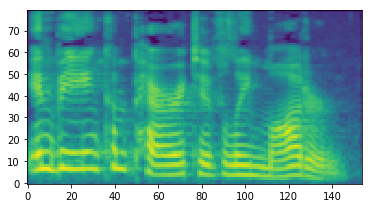

(80, 144)
25
has never been surpassed.


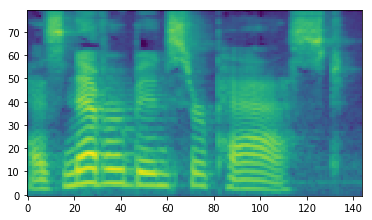

(80, 209)
43
than in the same operations with ugly ones.


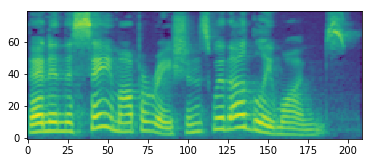

(80, 343)
59
and the next year Gunther Zeiner at Augsburg followed suit;


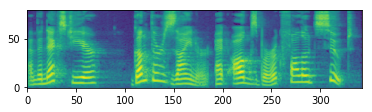

In [10]:
for i in range(len(metadata)):
    file_name = metadata[i, 0]
    text = metadata[i, 1]
    linear_path = os.path.join(specgram_folder, file_name + '.npy')
    mel_path = os.path.join(mel_folder, file_name + '.npy')
    mel_target = np.load(mel_path)
    linear_target = np.load(linear_path)
    
    print(mel_target.shape)
    print(len(text))
    print(text)
    
    plt.imshow(mel_target, origin='lower')
    plt.show()
    
    if i == 3:
        break

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, char_level=True)
tokenizer.fit_on_texts(chars)

tokenized_texts = tokenizer.texts_to_sequences(metadata[:, 1])

def dataset_generator():
    for file_name, tokens in zip(metadata[:, 0], tokenized_texts):
        linear_path = os.path.join(specgram_folder, file_name + '.npy')
        mel_path = os.path.join(mel_folder, file_name + '.npy')
        mel_target = np.load(mel_path)
        linear_target = np.load(linear_path)
        yield mel_target.T, linear_target.T, tokens

    return

In [12]:
dataset = tf.data.Dataset.from_generator(dataset_generator, (tf.float32, tf.float32, tf.int32), output_shapes=(tf.TensorShape([None, n_mels]), tf.TensorShape([None, 552]),tf.TensorShape([None, ])))

# dataset.shuffle(dataset_size)

W0717 17:58:00.256680 20412 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [13]:
def element_length_function(mel, linear, tokens):
    key = tf.size(tokens)
    return key

batch_size = 16

sequence_lengths = [i + 1 for i in range(16, max_sequence_len, 16)]
batch_sizes = [batch_size for i in range(len(sequence_lengths) + 1)]

dataset = dataset.apply(tf.data.experimental.bucket_by_sequence_length(element_length_function, sequence_lengths, batch_sizes))
dataset = dataset.prefetch(2)

W0717 17:58:00.295690 20412 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\experimental\ops\grouping.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
tacotron = Tacotron()

# Started hour
print(time.strftime("%Hh %Mm %Ss"))

for i, (mel, linear, texts) in enumerate(tqdm((dataset))):
    
    start = time.time()
    
    print(texts.shape)    
    loss, images = tacotron.train(mel, linear, texts)
    
    print(loss)
    print('Time taken for an epoch: {:.1f} sec'.format(time.time() - start))
    print(time.strftime("%Hh %Mm %Ss"))
    print('')
    
    plt.imshow(tf.transpose(images[0]), origin='lower')
    plt.colorbar()
    plt.show()

    plt.imshow(tf.transpose(images[2][:images[0].shape[0]]), origin='lower')
    plt.colorbar()
    plt.show()

    plt.imshow(tf.transpose(images[1]), origin='lower')
    plt.colorbar()
    ax = plt.gca()
    ax.set_aspect(0.15)
    plt.show()

    plt.imshow(tf.transpose(images[3][:images[1].shape[0]]), origin='lower')
    plt.colorbar()
    ax = plt.gca()
    ax.set_aspect(0.15)
    plt.show()
    
#     if i == 10:
#         break

17h 58m 21s


(16, 64)



KeyboardInterrupt: 